In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PriorVAE: using 07 training runs, compare the sample moments to original draws

In [11]:
from jax import random
import jax.numpy as jnp

import dill
from flax import serialization

# Numpyro
from numpyro.infer import  Predictive


## Load and generate draws

In [12]:
path = "./learnt_models/07_args_shorter_training.dill" # 

with open(path, "rb") as f:
    args = dill.load(f)

from reusable.util import decoder_filename, get_savepath
from reusable.vae import vae_sample
from reusable.vae import VAE_Decoder
from reusable.gp import OneDGP

rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))

gen_draws = {}

for i, loss_fn in enumerate(args["loss_functions"]):
    loss_fn = str.replace(loss_fn, ":", "-")
    for j in [0,1]:
        infinite = j ==0
        path_inf = "_inf" if infinite else ""
        
        file_path = f'{get_savepath()}/{decoder_filename("07", args, suffix=loss_fn+path_inf)}'

        try:
            dummy_decoder = VAE_Decoder(
                hidden_dim1=args["hidden_dim1"], hidden_dim2=args["hidden_dim2"], out_dim=args["n"]
            )
            dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

            with open(file_path, "rb") as file:
                bytes = file.read()

                args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

            plot_vae_predictive = Predictive(vae_sample, num_samples=10000)
            vae_draws = plot_vae_predictive(
                rng_key_predict,
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                decoder_params=args["decoder_params"],
            )["f"]

            gen_draws[f"{loss_fn}_{j}"]  = vae_draws
        except FileNotFoundError:
            print(f"Failed to load decoder params for loss_fn={loss_fn}, j={j}")



gp_predictive = Predictive(OneDGP, num_samples=10000)
gp_draws = gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']



## GP: 1D plots

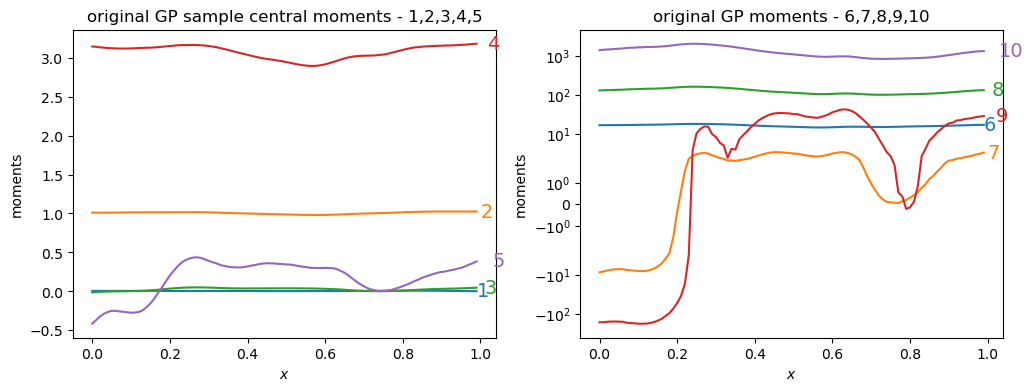

In [13]:
import matplotlib.pyplot as plt
from plotting.plots import plot_moments, plot_matrix
from reusable.moments import sample_central_moment, covariance, correlation_order, alt_correlation_order


moments_compareA = [1,2,3,4, 5]
moments_compareB = [6,7,8,9, 10]

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

gp_momentsA = [sample_central_moment(i, gp_draws) for i in moments_compareA]
plot_moments(gp_momentsA, moments_compareA, args["x"], "original GP sample central moments - " + ",".join([str(x) for x in moments_compareA]), ax=ax[0])

gp_momentsB = [sample_central_moment(i, gp_draws) for i in moments_compareB]
plot_moments(gp_momentsB, moments_compareB, args["x"], "original GP moments - " + ",".join([str(x) for x in moments_compareB]), scale="symlog", ax=ax[1])


## GPs: matrices

Created fig


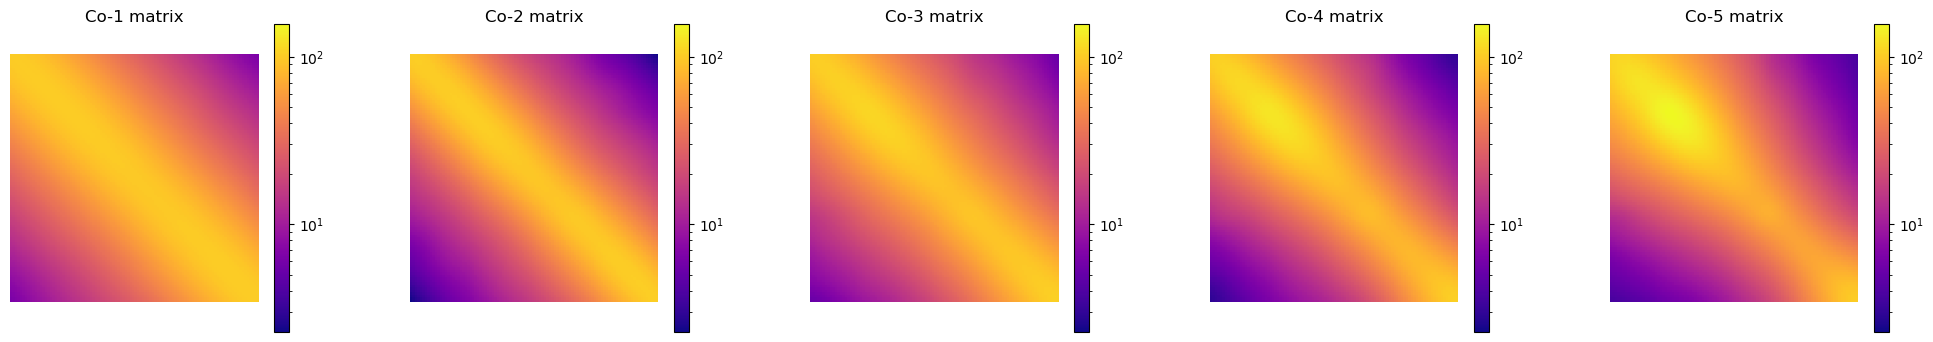

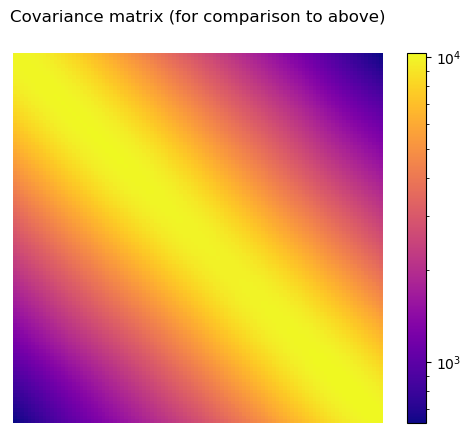

In [14]:
gp_mats = []

matrix_orders = [1,2,3,4,5]

fig = plt.figure(figsize=(4 * len(matrix_orders), 4))
mat_figs = fig.subfigures(nrows=1, ncols=len(matrix_orders))

for  i, order in enumerate(matrix_orders):
    gp_mats.append(alt_correlation_order(gp_draws, order))

vmin = min([jnp.min(m, axis=None) for m in gp_mats])

vmax = max([jnp.max(m, axis=None) for m in gp_mats])
for i, order in enumerate(matrix_orders):
    plot_matrix(gp_mats[i], f"Co-{order} matrix", vmin=vmin, vmax=vmax, fig=mat_figs[i])

fig.savefig("testB_gps.png")

plot_matrix(covariance(gp_draws, ), "Covariance matrix (for comparison to above)")


# Comparing training plots

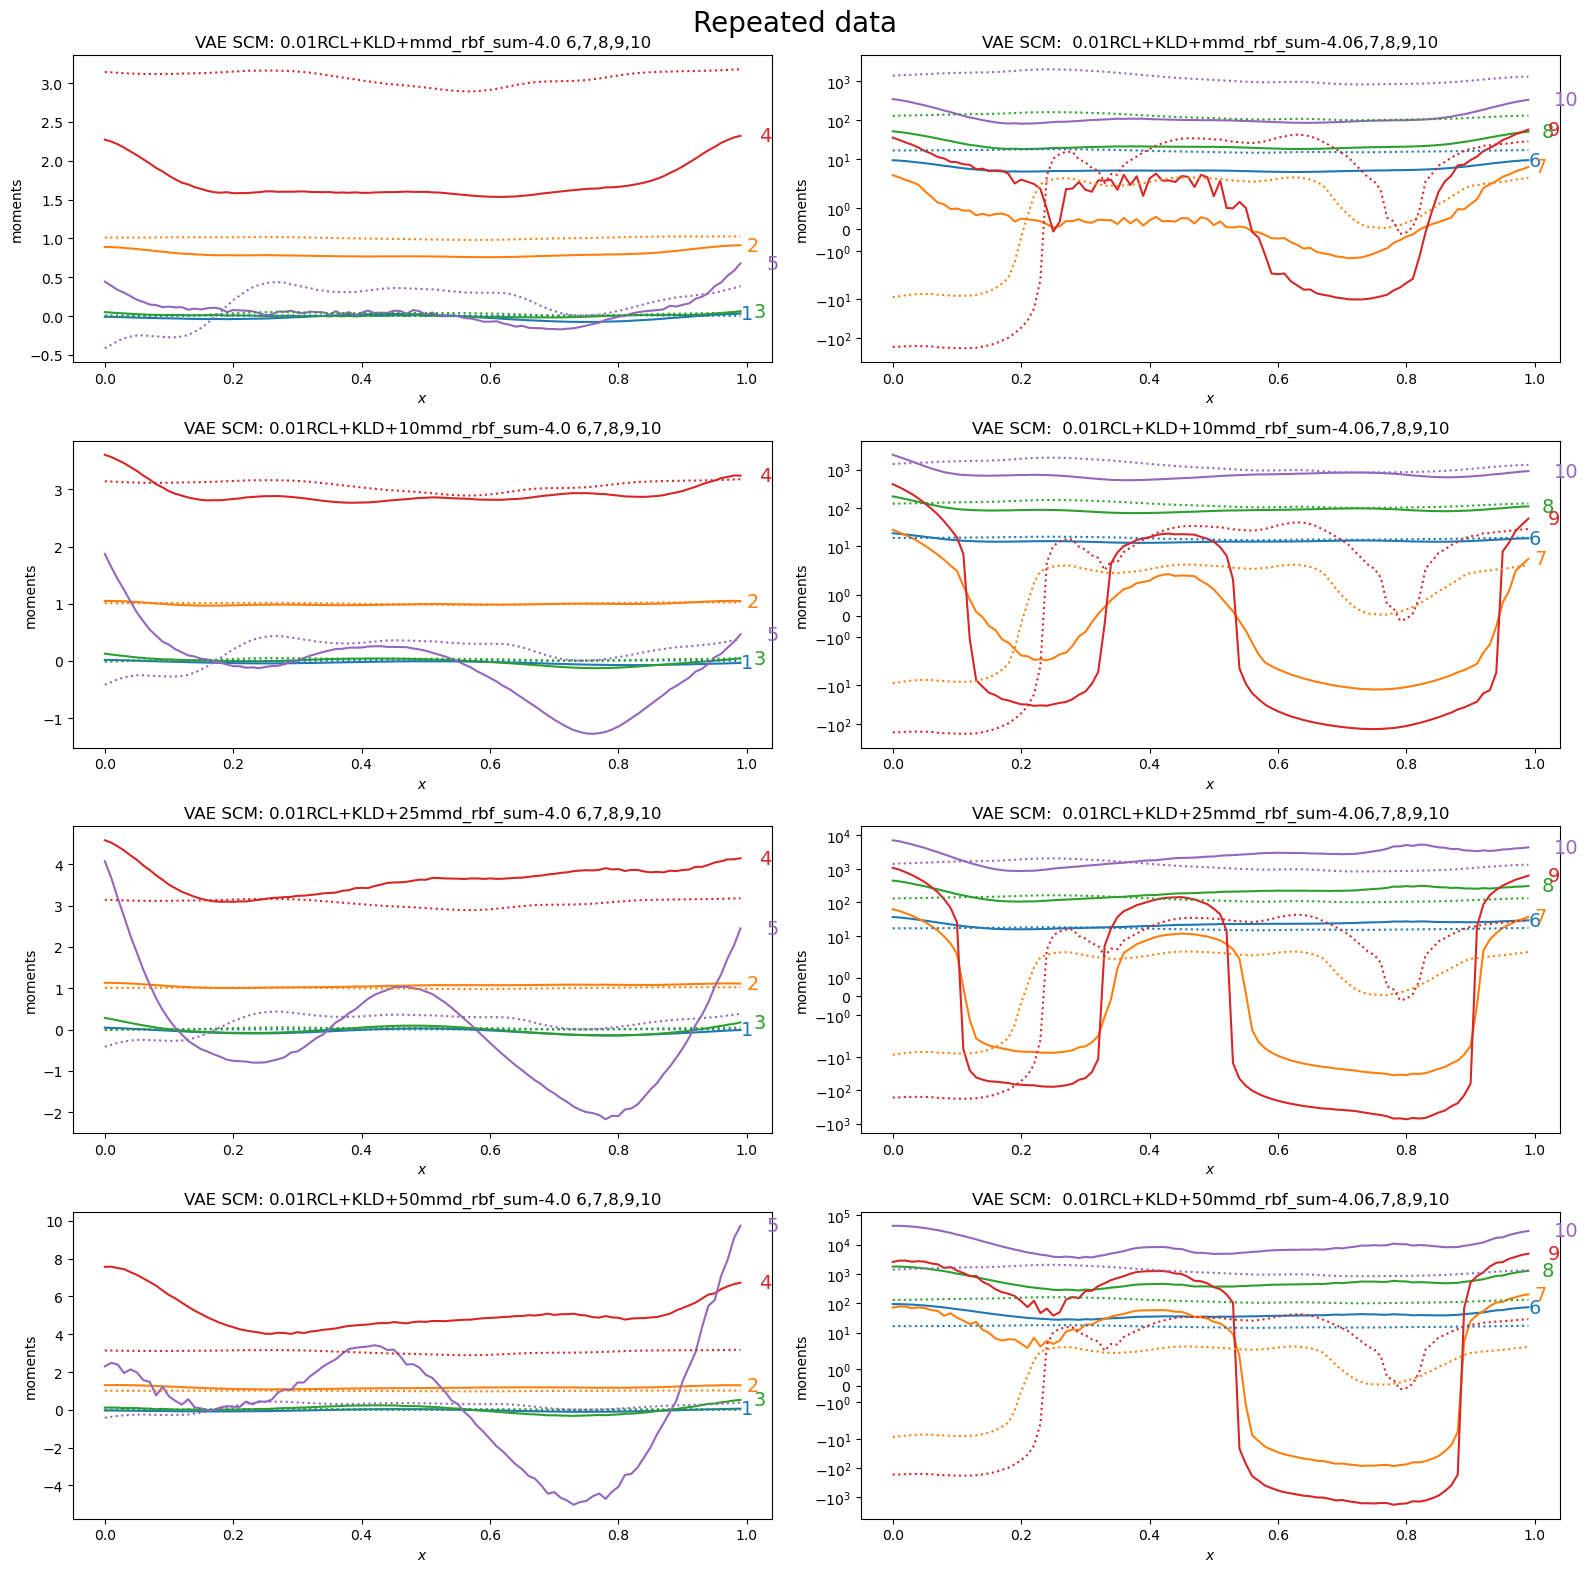

In [19]:
from plotting.plots import plot_moments
moments_fig, moments_ax = plt.subplots(nrows=len(args["loss_functions"]), ncols=2, figsize=(16, 16))
moments_fig.suptitle("Repeated data", fontsize=20)
# inf_moments_fig, inf_moments_ax = plt.subplots(nrows=len(args["loss_functions"]), ncols=2, figsize=(16, 16))
# inf_moments_fig.suptitle("Infinite data", fontsize=20)

for i, loss_fn in enumerate(args["loss_functions"]):
    loss_fn = str.replace(loss_fn, ":", "-")

    try:
        vae_draws = gen_draws[f"{loss_fn}_{j}"]
        
        vae_momentsA = [sample_central_moment(i, vae_draws) for i in moments_compareA]
        vae_momentsB = [sample_central_moment(i, vae_draws) for i in moments_compareB]

        plot_moments(vae_momentsA, moments_compareA, args["x"], f"VAE SCM: {loss_fn} " + ",".join([str(x) for x in moments_compareB]), ax=moments_ax[i, 0], correct_moments=gp_momentsA)
        plot_moments(vae_momentsB, moments_compareB, args["x"], f"VAE SCM:  {loss_fn}" + ",".join([str(x) for x in moments_compareB]), ax=moments_ax[i, 1], correct_moments=gp_momentsB, scale="symlog")

    except KeyError:
        print(f"Failed to load decoder params for loss_fn={loss_fn}, j={j}")

moments_fig.tight_layout()

## Matrices

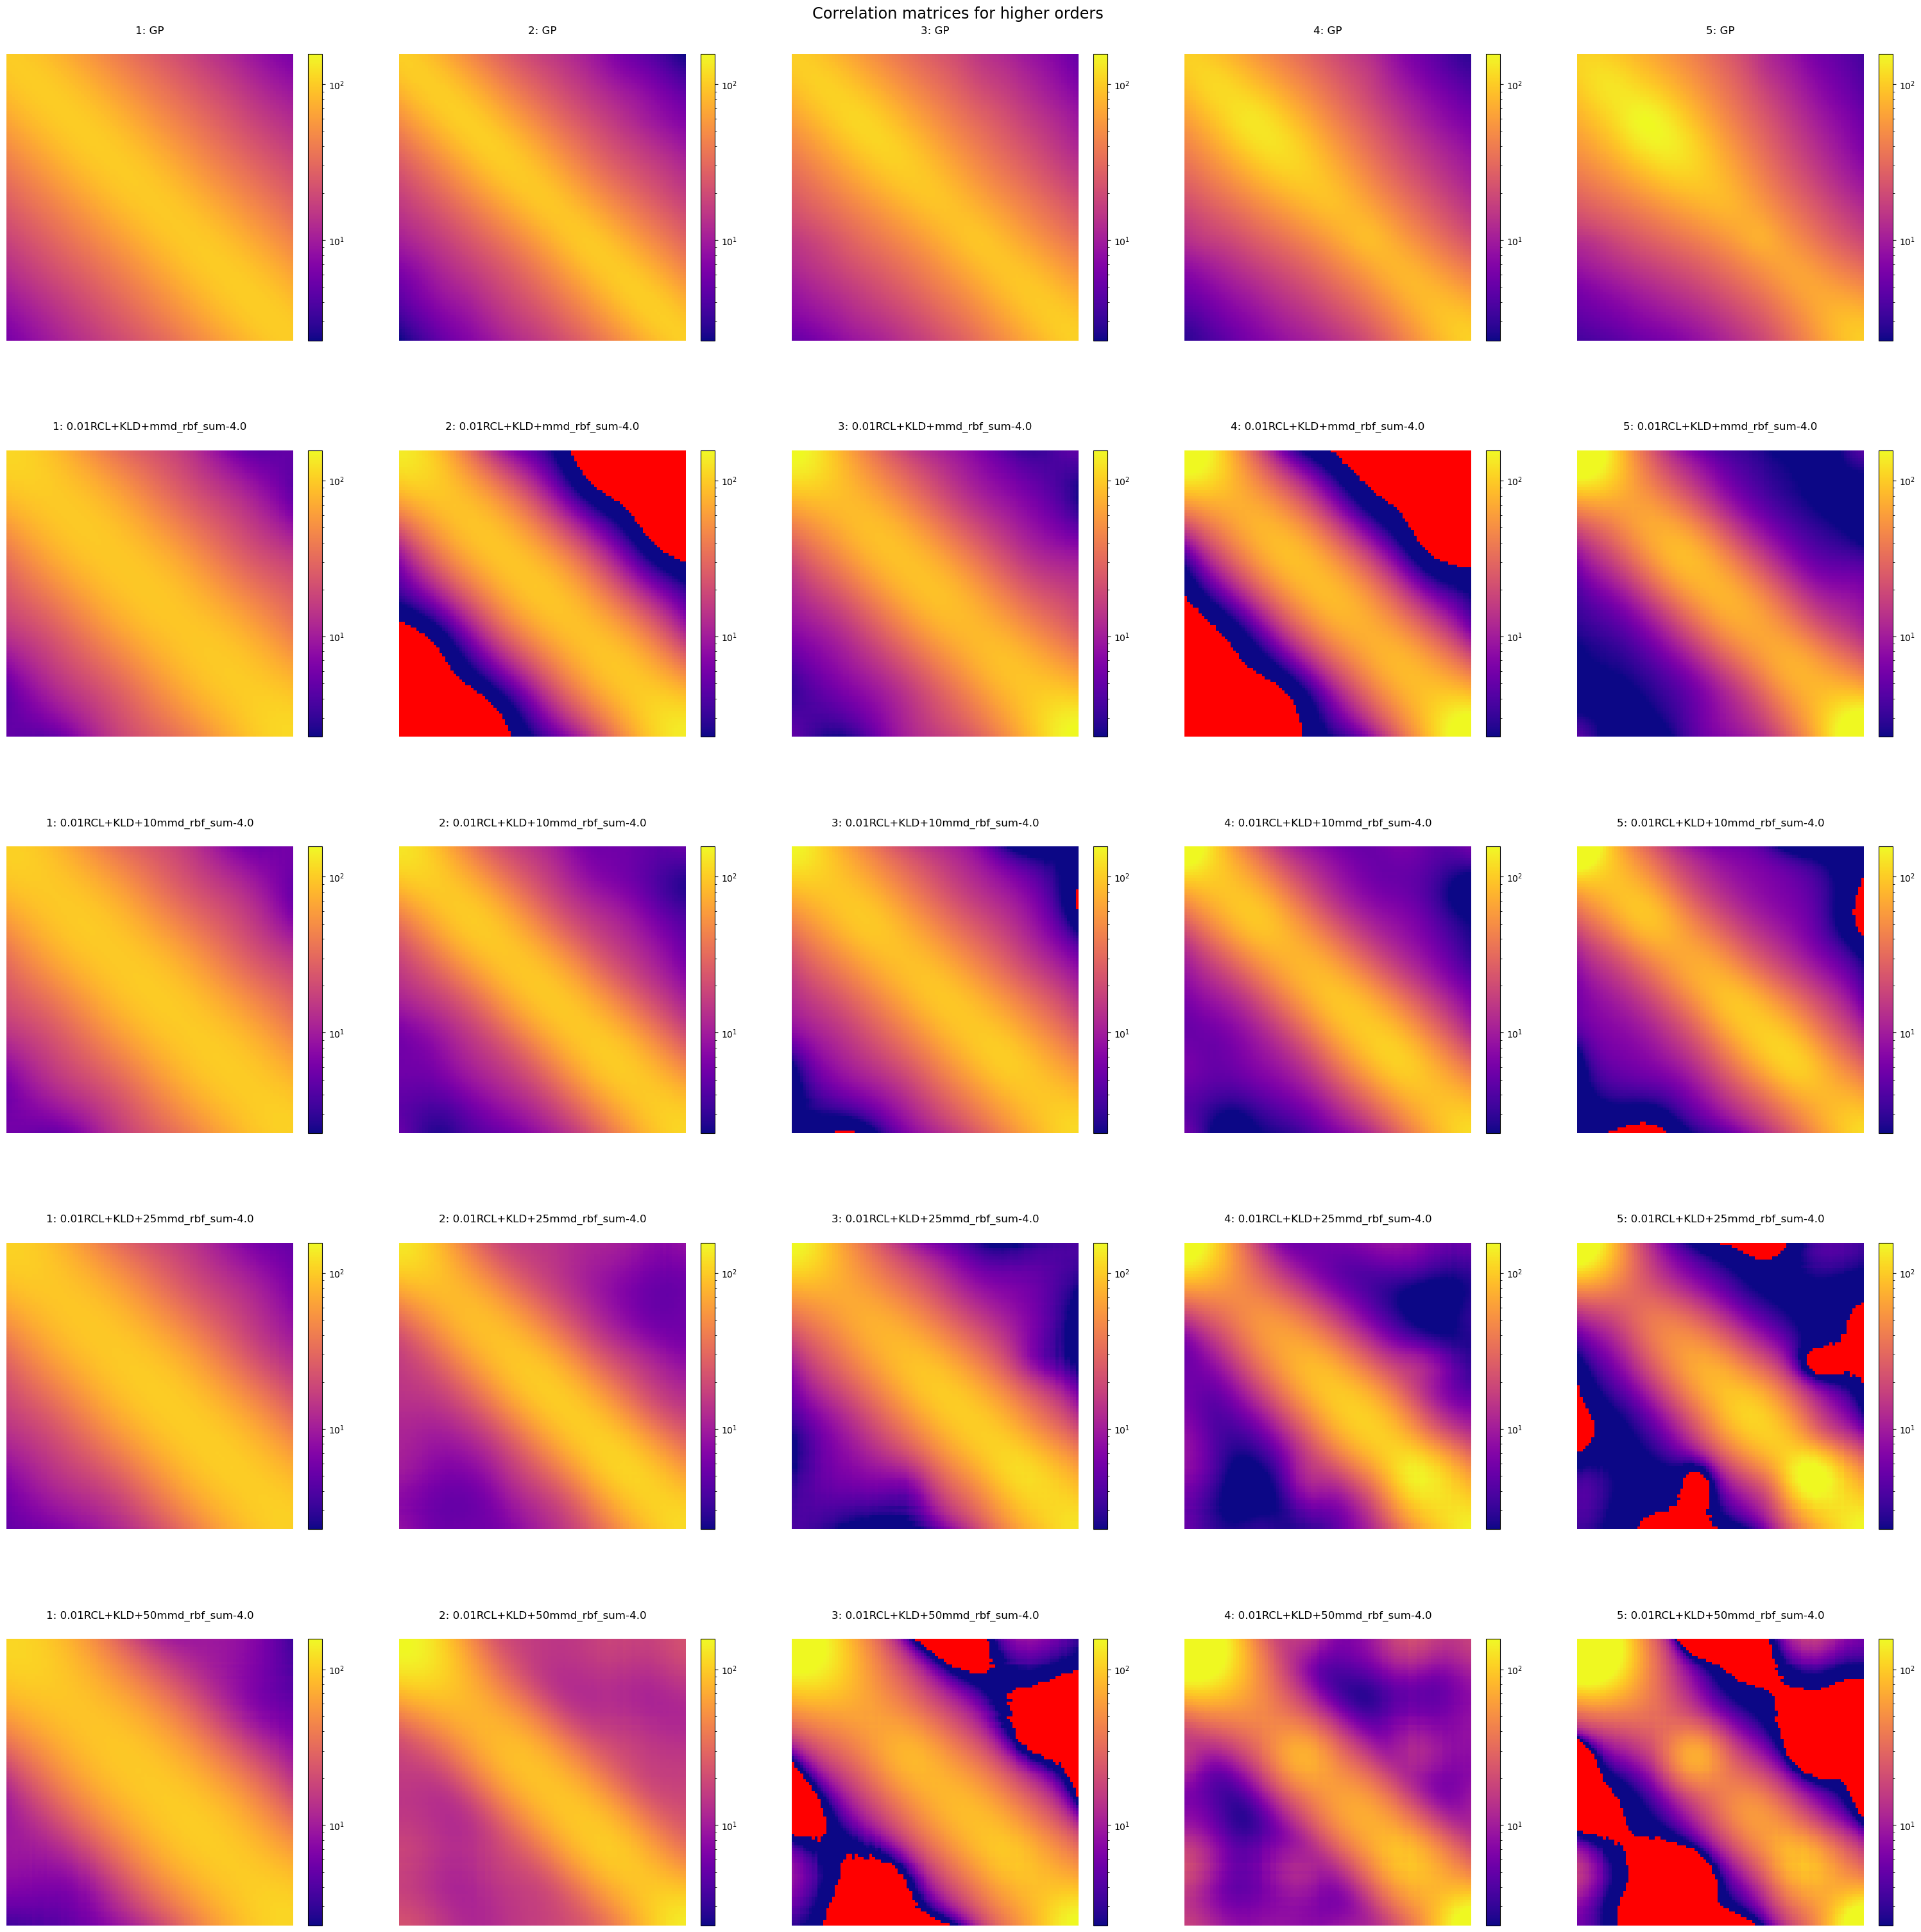

In [20]:
fig = plt.figure(layout='constrained', figsize=(6 * len(matrix_orders), 6+ 6 * len(args["loss_functions"])))
subfigs = fig.subfigures(nrows=1+len(args["loss_functions"]), ncols=len(matrix_orders), wspace=0.1, hspace=0.2)

for k, order in enumerate(matrix_orders):
    plot_matrix(gp_mats[k], f"{order}: GP", vmin=vmin, vmax=vmax, fig=subfigs[0,k])

frob_norms = jnp.ones(shape=(len(args["loss_functions"]), len(matrix_orders)))

for i, loss_fn in enumerate(args["loss_functions"]):
    loss_fn = str.replace(loss_fn, ":", "-")
    try:
        vae_draws = gen_draws[f"{loss_fn}_1"]
    
        for k, order in enumerate(matrix_orders):
            mat = alt_correlation_order(vae_draws, order)
            plot_matrix(mat, f"{order}: {loss_fn}", vmin=vmin, vmax=vmax,  fig=subfigs[i+1,k])
            frob_norms = frob_norms.at[i,k].set(jnp.linalg.norm(mat - gp_mats[k], ord="fro"))
                   
    except KeyError:
        print(f"Failed to load decoder params for loss_fn={loss_fn}, j={j}")


fig.suptitle('Correlation matrices for higher orders', fontsize='xx-large')

plt.show()

In [21]:
frob_norms

Array([[ 350.958  , 1222.9082 , 1273.839  , 2340.3057 , 2980.667  ],
       [ 314.07996,  557.1584 ,  944.6498 , 1750.0927 , 2608.0723 ],
       [ 432.35757,  766.01263, 1656.753  , 2734.1943 , 3967.485  ],
       [ 714.3762 , 1064.5734 , 2331.3132 , 3102.8103 , 4262.937  ]],      dtype=float32)

## Compare MMD

Done 0, 0
Done 0, 1
Done 0, 2
Done 0, 3
Done 0, 4
Done 0, 5
Done 0, 6
Done 1, 0
Done 1, 1
Done 1, 2
Done 1, 3
Done 1, 4
Done 1, 5
Done 1, 6
Done 2, 0
Done 2, 1
Done 2, 2
Done 2, 3
Done 2, 4
Done 2, 5
Done 2, 6
Done 3, 0
Done 3, 1
Done 3, 2
Done 3, 3
Done 3, 4
Done 3, 5
Done 3, 6


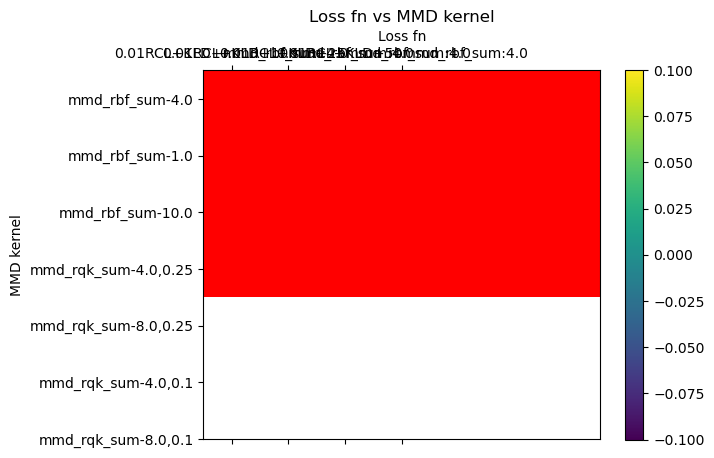

In [23]:
import numpy as onp
from reusable.loss import MMD_rbf, MMD_rqk, MMD_rbf_sum, MMD_rqk_sum
from plotting.plots import plot_mmd_matrix

mmd_comp_kernels = [
    MMD_rbf(4.0, True),
    MMD_rbf(1.0, True),
    MMD_rbf(10.0, True),
    MMD_rqk(4.0, 0.25, True),
    MMD_rqk(8.0, 0.25, True),
    MMD_rqk(4.0, 0.1, True),
    MMD_rqk(8.0, 0.1, True),
]


# CAN ONLY COMPARE IN A COLUMN!!!!

mmd_values = onp.ones((len(args["loss_functions"]), len(mmd_comp_kernels)))
mmd_values.fill(onp.nan)

for i, loss_fn in enumerate(args["loss_functions"]):
    loss_fn = str.replace(loss_fn, ":", "-")
    try:
        vae_draws = gen_draws[f"{loss_fn}_1"]

        for k, mmd in enumerate(mmd_comp_kernels):

            mmd_values[i, k] = mmd(gp_draws, vae_draws)
            print(f"Done {i}, {k}")
    except KeyError:
        print(f"Failed to load decoder params for loss_fn={loss_fn}, j={j}")

plot_mmd_matrix(
    mmd_values,
    onp.full_like(mmd_values, True),
    [l.__name__ for l in mmd_comp_kernels],
    args["loss_functions"],
    "MMD kernel",
    "Loss fn",
    f"Loss fn vs MMD kernel",
)


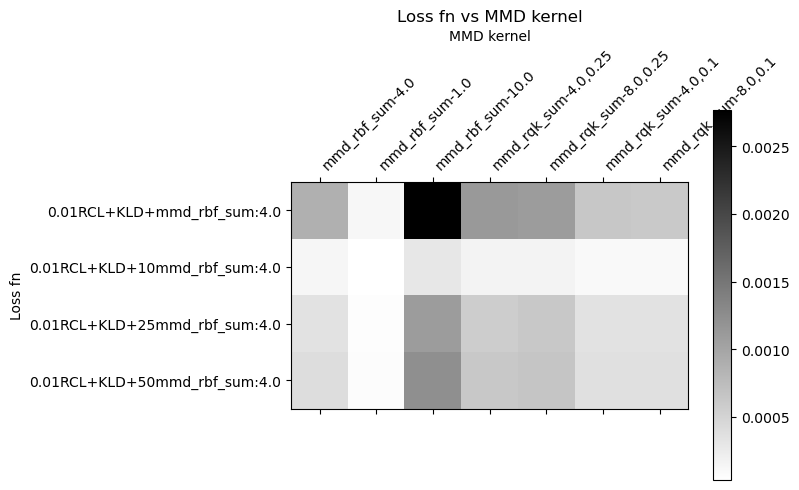

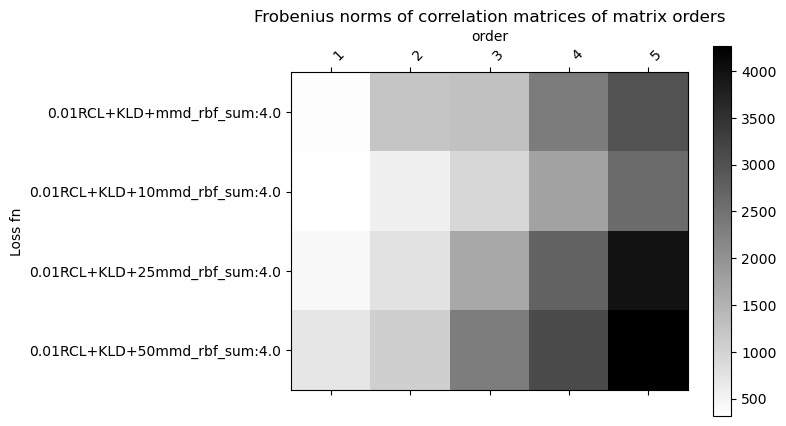

In [36]:
from plotting.plots import plot_mmd_matrix

plot_mmd_matrix(
    mmd_values,
    onp.full_like(mmd_values, False),
    
    args["loss_functions"],
    [l.__name__ for l in mmd_comp_kernels],
    
    "Loss fn",
    "MMD kernel",
    f"Loss fn vs MMD kernel",
)

plot_mmd_matrix(
    frob_norms,
    onp.full_like(frob_norms, False),
    
    args["loss_functions"],
    matrix_orders,
    
    "Loss fn",
    "order",
    f"Frobenius norms of correlation matrices of matrix orders",
)